# Late Fusion Model - CMU-MOSEI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 301 (delta 127), reused 168 (delta 74), pack-reused 70 (from 1)
Receiving objects: 100% (301/301), 195.03 MiB | 52.75 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Updating files: 100% (58/58), done.


In [3]:
import gdown

file_id = "1zFOBHijVppTiyteSsi0aTFYPEsda_AOk"
destination = "mosei_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk
From (redirected): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk&confirm=t&uuid=203e85f9-1dda-4047-b62d-928e6e0ca73c
To: /content/mosei_raw.pkl
100%|██████████| 9.94G/9.94G [00:52<00:00, 191MB/s]


'mosei_raw.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRU, MLP
from training.supervised import train, test
from fusions.modules import Concat
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
train_data, valid_data, test_data = get_dataloader('/content/mosei_raw.pkl')

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [9]:
encoders = [
    GRU(713, 70, dropout=True, has_padding=True, batch_first=True).to(device),
    GRU(74, 200, dropout=True, has_padding=True, batch_first=True).to(device),
    GRU(300, 600, dropout=True, has_padding=True, batch_first=True).to(device),
]
head = MLP(870, 870, 1).to(device)
fusion = Concat().to(device)

## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = 'MOSEI_Late_Fusion'
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 0.7079
Valid Loss: 0.6052
Saving Best

Epoch [2/100]
Train Loss: 0.6298
Valid Loss: 0.5885
Saving Best

Epoch [3/100]
Train Loss: 0.5971
Valid Loss: 0.5891

Epoch [4/100]
Train Loss: 0.5612
Valid Loss: 0.5751
Saving Best

Epoch [5/100]
Train Loss: 0.5227
Valid Loss: 0.5831

Epoch [6/100]
Train Loss: 0.4827
Valid Loss: 0.5932

Epoch [7/100]
Train Loss: 0.4391
Valid Loss: 0.5956

Epoch [8/100]
Train Loss: 0.3940
Valid Loss: 0.6186

Epoch [9/100]
Train Loss: 0.3548
Valid Loss: 0.6121

Epoch [10/100]
Train Loss: 0.3207
Valid Loss: 0.6166

Epoch [11/100]
Train Loss: 0.2952
Valid Loss: 0.6169

Epoch [12/100]
Train Loss: 0.2718
Valid Loss: 0.6137

Epoch [13/100]
Train Loss: 0.2551
Valid Loss: 0.6000

Epoch [14/100]
Train Loss: 0.2431
Valid Loss: 0.6044

Epoch [15/100]
Train Loss: 0.2337
Valid Loss: 0.6213

Epoch [16/100]
Train Loss: 0.2220
Valid Loss: 0.6122

Epoch [17/100]
Train Loss: 0.2133
Valid Loss: 0.6036

Epoch [18/100]
Train Loss: 0.2072
Valid Loss: 0.6197

E

Text(0.5, 1.0, 'Loss vs. No. of epochs')

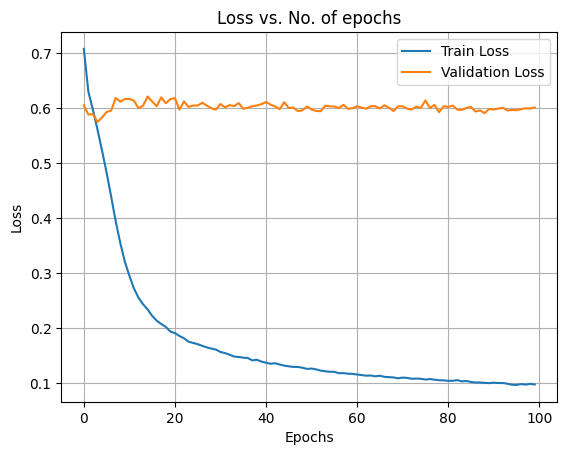

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [12]:
save_results(train_losses, valid_losses, f"/content/{OUTPUT_MODEL_FILE_NAME}.pkl")

## Testing

In [13]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)
test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-13-6e4fea1da98f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 80.7534% | Total Accuracy: 71.6002%
Inference Time: 2s310ms
Inference Params: 2712691
